<a href="https://colab.research.google.com/github/keunsooyoon/Algorithms/blob/main/Emergence_in_SAT_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The variation in results across multiple executions is an inherent consequence of randomized instance generation.
Each SAT instance is constructed using stochastic processes, resulting in unique clause compositions on every run.
As a result, satisfiability ratios and solving times are naturally subject to fluctuation.
This variability is not a flaw but a reflection of the problem's probabilistic landscape.
It serves to capture the broader behavior of SAT solvers across diverse conditions, rather than a fixed scenario.

KEUNSOO YOON (austiny@snu.ac.kr / austiny@gatech.edu)

DOI: 10.36227/techrxiv.174682135.51838369/v1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
  Created wheel for pypblib: filename=pypblib-0.0.4-cp311-cp311-linux_x86_64.whl size=2973732 sha256=380045da29c318b0deb6185c69f398624d6468a2058685e231050b1c390a2c48
  Stored in directory: /root/.cache/pip/wheels/55/c5/26/eb71ff12b35b705794daf31cbd226a9aac7a40866ad4df7e73
Successfully built pypblib


Running for n=100: 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


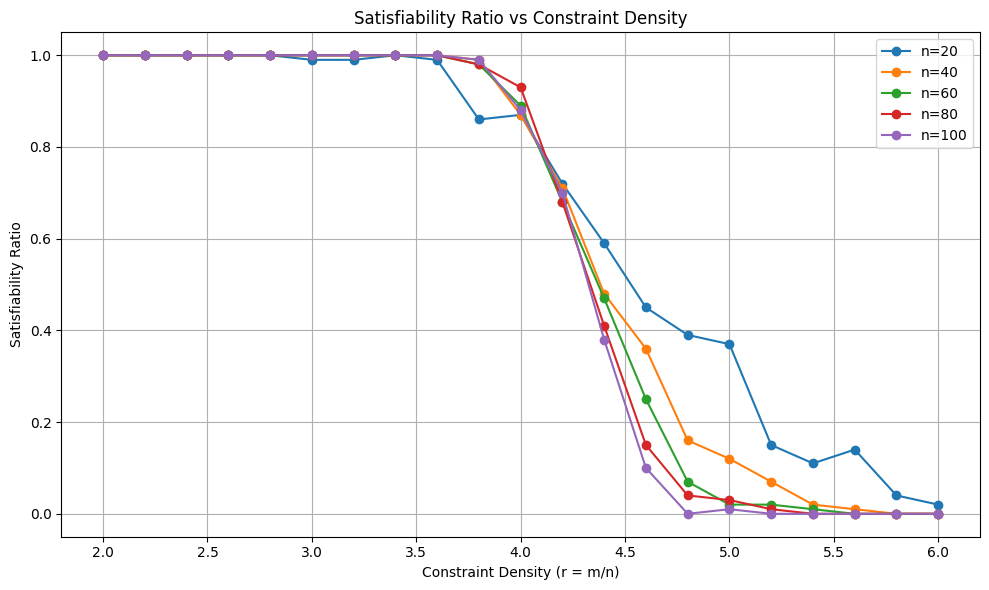

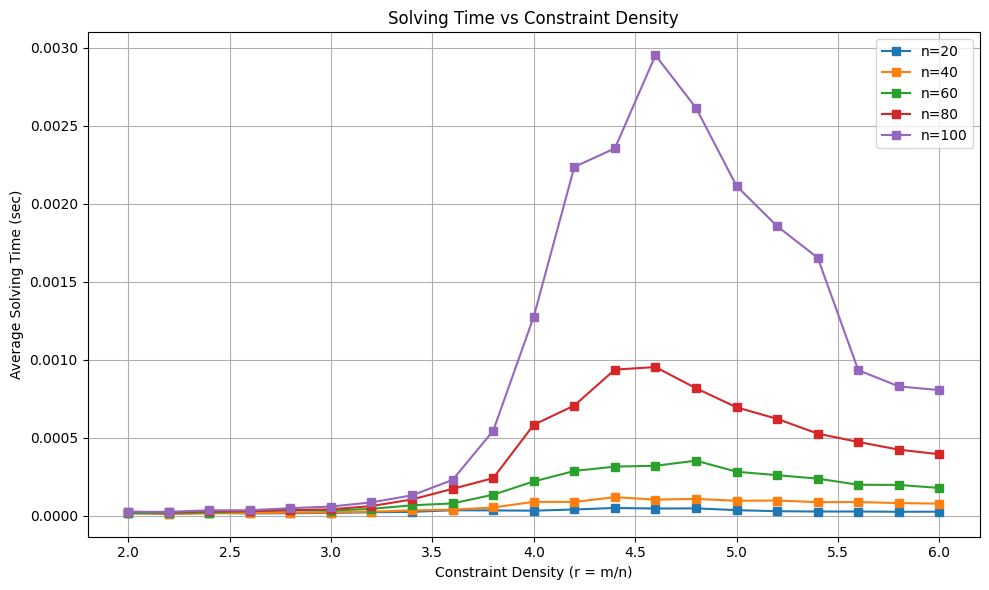

In [7]:
# Install PySAT (only needed on Google Colab)
!pip install python-sat[pblib,aiger]

# Import required libraries
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from pysat.solvers import Glucose3
from tqdm import tqdm  # For progress bar

# Experiment configuration
n_values = [20, 40, 60, 80, 100]        # Number of variables
r_values = np.arange(2.0, 6.1, 0.2)     # Constraint density (m/n)
instances_per_setting = 100             # Number of SAT instances per setting

# Dictionary to store experiment results
results = {}

# Function: Generate a random 3-SAT instance
def generate_3sat_instance(n, m):
    """
    Generates a random 3-SAT CNF instance with n variables and m clauses.
    Each clause contains 3 literals, with 50% chance of negation.
    """
    clauses = []
    for _ in range(m):
        vars = random.sample(range(1, n + 1), 3)  # Choose 3 distinct variables
        clause = []
        for v in vars:
            clause.append(-v if random.random() < 0.5 else v)
        clauses.append(clause)
    return clauses

# Run experiment for each combination of (n, r)
for n in n_values:
    sat_ratios = []   # Satisfiability ratio per r
    avg_times = []    # Average solving time per r

    for r in tqdm(r_values, desc=f"Running for n={n}"):
        m = int(r * n)       # Number of clauses
        sat_count = 0        # Number of satisfiable instances
        total_time = 0.0     # Total solving time

        for _ in range(instances_per_setting):
            cnf = generate_3sat_instance(n, m)  # Generate CNF
            solver = Glucose3()                 # Initialize SAT solver

            for clause in cnf:
                solver.add_clause(clause)

            start = time.time()
            sat = solver.solve()
            elapsed = time.time() - start

            if sat:
                sat_count += 1
            total_time += elapsed

            solver.delete()

        # Compute statistics for this (n, r) setting
        sat_ratio = sat_count / instances_per_setting
        avg_time = total_time / instances_per_setting
        sat_ratios.append(sat_ratio)
        avg_times.append(avg_time)

    # Save results for this n
    results[n] = {
        'r': list(r_values),
        'sat_ratio': sat_ratios,
        'avg_time': avg_times
    }

# Plot 1: Satisfiability Ratio vs Constraint Density
plt.figure(figsize=(10, 6))
for n in n_values:
    plt.plot(results[n]['r'], results[n]['sat_ratio'],
             label=f'n={n}', marker='o')
plt.xlabel("Constraint Density (r = m/n)")
plt.ylabel("Satisfiability Ratio")
plt.title("Satisfiability Ratio vs Constraint Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("satisfiability_ratio.png")
plt.show()

# Plot 2: Average Solving Time vs Constraint Density
plt.figure(figsize=(10, 6))
for n in n_values:
    plt.plot(results[n]['r'], results[n]['avg_time'],
             label=f'n={n}', marker='s')
plt.xlabel("Constraint Density (r = m/n)")
plt.ylabel("Average Solving Time (sec)")
plt.title("Solving Time vs Constraint Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("solving_time.png")
plt.show()


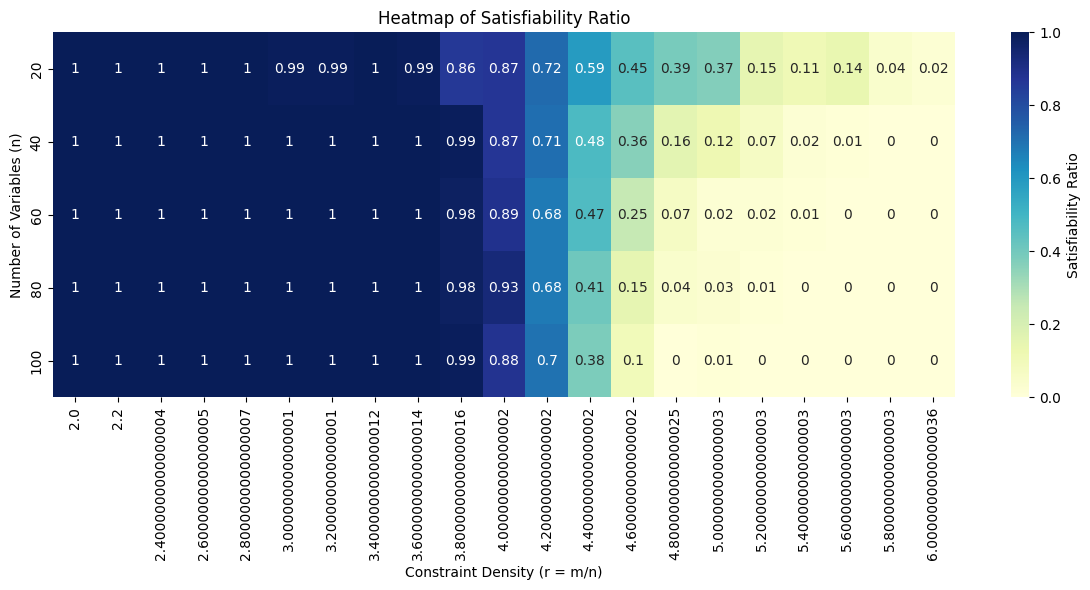

In [8]:
# Plot 3: Heatmap of Satisfiability Ratios (n vs r)
import seaborn as sns
import pandas as pd
import numpy as np

# Prepare heatmap data
heatmap_data = []
for n in n_values:
    for r, ratio in zip(results[n]['r'], results[n]['sat_ratio']):
        heatmap_data.append({'n': n, 'r': r, 'sat_ratio': ratio})
df_heatmap = pd.DataFrame(heatmap_data)

# Pivot for heatmap
heatmap_matrix = df_heatmap.pivot(index='n', columns='r', values='sat_ratio')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Satisfiability Ratio'})
plt.title("Heatmap of Satisfiability Ratio")
plt.xlabel("Constraint Density (r = m/n)")
plt.ylabel("Number of Variables (n)")
plt.tight_layout()
plt.savefig("satisfiability_heatmap.png")
plt.show()


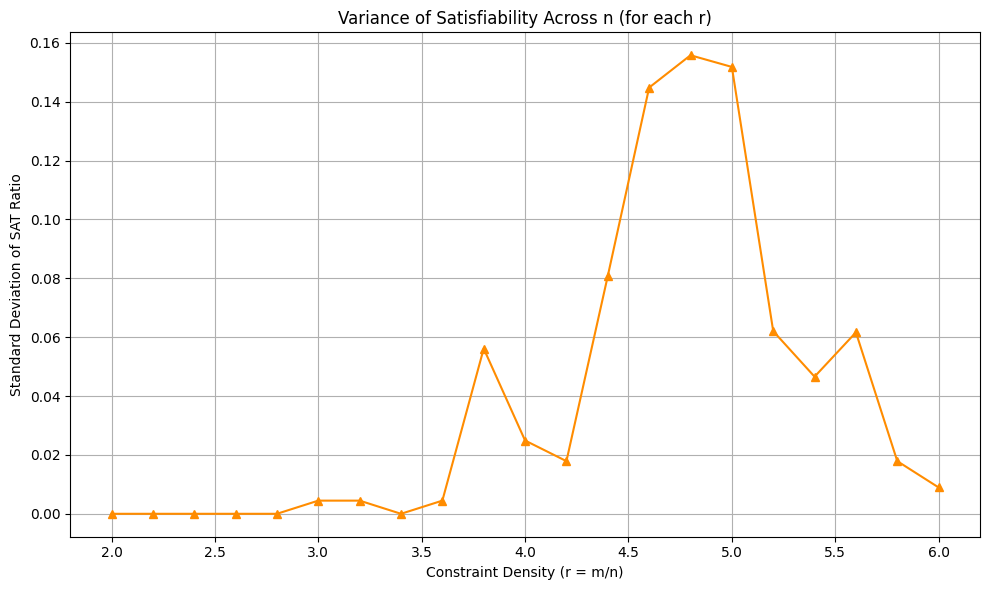

In [9]:
# Plot 4: Standard Deviation of Satisfiability Ratios across n (for each r)
import statistics

std_devs = []
for i in range(len(r_values)):
    # 각 r 위치에 대해 n별 sat_ratio 값 모아서 표준편차 계산
    values = [results[n]['sat_ratio'][i] for n in n_values]
    std_dev = statistics.stdev(values)
    std_devs.append(std_dev)

plt.figure(figsize=(10, 6))
plt.plot(r_values, std_devs, marker='^', linestyle='-', color='darkorange')
plt.xlabel("Constraint Density (r = m/n)")
plt.ylabel("Standard Deviation of SAT Ratio")
plt.title("Variance of Satisfiability Across n (for each r)")
plt.grid(True)
plt.tight_layout()
plt.savefig("sat_ratio_stddev.png")
plt.show()